# Part 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from keras import initializers,regularizers
from math import sqrt

## Preprocessing

In [2]:
#filenames
str0="ts_comp_N10000"
fnamex = "x_"+str0+".csv"
fnamey = "y_"+str0+".csv"

#data
x = np.loadtxt(fnamex,delimiter=",",dtype=float)
N = len(x)

#Labels
categ = np.loadtxt(fnamey,delimiter=",",dtype=int)
N_categ=3
y = np.zeros((N,N_categ))
for n in range(N):y[n][categ[n]] = 1 #one-hot encoding

#Training and Validation sets
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

L = len(x[0])

print(f"\nNumber of total samples: {N}\nSamples in the Training Set: {N_train}\nSamples in Validation Set:{N_val}\nLength of each Sample:{L}")

#reshape the data
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)



Number of total samples: 10000
Samples in the Training Set: 8000
Samples in Validation Set:2000
Length of each Sample:60


### data manipulation

In [3]:
differences = x[:,1:]-x[:,:-1]-5

tmp_data = np.sort(np.concatenate(np.abs(differences)))
N_tmp_data = len(tmp_data)
N_classes = 3
limits = [tmp_data[int(i*N_tmp_data/N_classes)] for i in range(1,N_classes)]


differences[np.abs(differences) <= limits[0]] = 0

for j in range(1,len(limits)):
    differences[(limits[j-1] < differences) & (differences <= limits[j])] = j
    
for j in range(1,len(limits)):
    differences[(differences <= -limits[j-1]) & (-limits[j] < differences)] = -j
    
differences[(limits[-1] <= differences)] = N_classes-1
differences[(differences <= -limits[-1])] = -N_classes+1

differences = (differences+N_classes-1)

In [4]:
Nc= 2*N_classes - 1
new_x = np.zeros((N,L-1,Nc)) #every row is an input

for n in range(N): #for each sample
    for i in range(L-1): #for each character
        new_x[n][i][int(differences[n][i])] = 1


In [5]:
new_x = new_x.reshape(new_x.shape[0], new_x.shape[1], new_x.shape[2], 1)

new_x_train = new_x[:N_train]
new_x_val = new_x[N_train:]

print(new_x_train.shape)
print(new_x_train[0])

(8000, 59, 5, 1)
[[[0.]
  [0.]
  [0.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [1.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [1.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]


### augmenting data

In [6]:
#specchiare
new_x_train = np.concatenate((new_x_train[:,::-1], new_x_train))
y_train = np.concatenate((y_train, y_train))

## Defining, compiling and fitting the model 

In [7]:
#define the model
from keras import regularizers, initializers
from keras.optimizers import SGD, Adam, RMSprop

def model(learning_rate = 0.01, momentum = 0.9,activation="relu",dropout_rate=0.1, n_f1 = 3, n_f2 = 3,optimizer = 0, N_l1 = 25, reg = 0.00017):
    
    opt1 = SGD(learning_rate=learning_rate,
            momentum=momentum,
            nesterov=True)

    opt3 = Adam(learning_rate=learning_rate)
    opt = [opt1,opt3]

    # create the model
    model = Sequential()
    
    model.add(Conv2D(filters=n_f1,kernel_size=(12,Nc), 
                 activation=activation,
                 input_shape=(L-1,Nc,1),
                 kernel_regularizer=regularizers.l1(reg),
                 kernel_initializer=initializers.RandomNormal(mean=0,stddev=sqrt(2/12))
                 ))
    model.add(AveragePooling2D((3,1))) #first and only pooling;
    
    model.add(Conv2D(filters=n_f2,kernel_size=(4,1), 
                 activation=activation,
                 ))
    model.add(AveragePooling2D((3,1)))
    model.add(Flatten())
    model.add(Dense(N_l1,activation=activation)) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(3,activation="softmax"))
    
    # compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt[optimizer],
                  metrics=['accuracy'])
    return model

In [8]:
model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 1, 3)          183       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 1, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 1, 3)          39        
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 1, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                325       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0

### Since we used dropout_rate=0.1 at the layer dense_48 we noticed that each iteration the algorithm will learn more or less 625-325*0.1=593 parameters

In [14]:
import random 
random.seed(1567)
fit_model = model()
fit = fit_model.fit(new_x_train, y_train,
              epochs=50, batch_size=25,
              validation_data=(new_x_val,y_val),
              shuffle=True)

Epoch 1/50
640/640 [==============================] - 1s 2ms/step - loss: 1.0683 - accuracy: 0.3964 - val_loss: 0.8489 - val_accuracy: 0.5915
Epoch 2/50
640/640 [==============================] - 1s 1ms/step - loss: 0.8516 - accuracy: 0.6012 - val_loss: 0.7764 - val_accuracy: 0.6490
Epoch 3/50
640/640 [==============================] - 1s 1ms/step - loss: 0.7733 - accuracy: 0.6521 - val_loss: 0.7346 - val_accuracy: 0.6640
Epoch 4/50
640/640 [==============================] - 1s 2ms/step - loss: 0.7005 - accuracy: 0.6934 - val_loss: 0.6389 - val_accuracy: 0.7350
Epoch 5/50
640/640 [==============================] - 1s 2ms/step - loss: 0.5830 - accuracy: 0.7679 - val_loss: 0.5384 - val_accuracy: 0.7840
Epoch 6/50
640/640 [==============================] - 1s 2ms/step - loss: 0.5480 - accuracy: 0.7799 - val_loss: 0.5246 - val_accuracy: 0.7975
Epoch 7/50
640/640 [==============================] - 1s 2ms/step - loss: 0.5192 - accuracy: 0.7932 - val_loss: 0.5197 - val_accuracy: 0.7970
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.3969 - accuracy: 0.8650

Test loss: 0.39693525433540344
Test accuracy: 0.8650000095367432


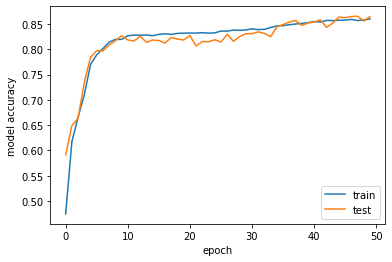

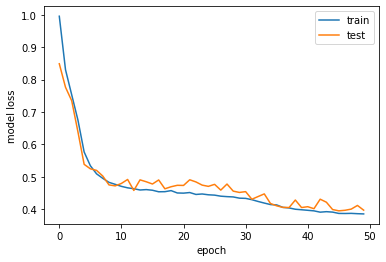

In [15]:
#Plot the results

score = fit_model.evaluate(new_x_val, y_val, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()